[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/moh-meh/git_test/blob/master/task_tf.ipynb)

In [1]:
import os
import math
import random
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

import tensorflow as tf
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

from tensorflow import keras
from tensorflow.keras import layers

E:\Softwares\anaconda3\envs\tf\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


Num GPUs Available: 1


In [2]:
BASE_dir = '../Datasets/lego/star-wars_images/'
names = ["YODA", "LUKE SKYWALKER", "R2-D2", "MACE WINDU", "GENERAL GRLEVOUS"]

tf.random.set_seed(1)
# this ensures that we get the same sequence of random numbers each time we run our code for more Reproducibility

In [31]:
# Read and distribute information from the dataset
if not os.path.isdir(BASE_dir + 'train/'):
    for name in names:
        os.makedirs(BASE_dir + 'train/' + name)
        os.makedirs(BASE_dir + 'val/' + name)
        os.makedirs(BASE_dir + 'test/' + name)
        
data_folders = ["0001/", "0002/", "0003/", "0004/", "0005/"]  
for folder_idx, folder in enumerate(data_folders):
    files = os.listdir(BASE_dir + folder)
    number_of_images = len(files)
    n_train = int((number_of_images * 0.6))
    n_valid = int((number_of_images * 0.25))
    n_test = number_of_images - n_train - n_valid
    print(number_of_images, n_train, n_valid, n_test)
    for file_idx, file in enumerate(files):
        file_name = BASE_dir + folder + file
        if file_idx < n_train:
            shutil.move(file_name, BASE_dir + "train/" + names[folder_idx])
        elif file_idx < n_train + n_valid:
            shutil.move(file_name, BASE_dir + "val/" + names[folder_idx])
        else:
            shutil.move(file_name, BASE_dir + "test/" + names[folder_idx])

12 7 3 2
12 7 3 2
12 7 3 2
13 7 3 3
14 8 3 3


In [4]:
# Generate batches of tensor image data with real-time data augmentation
train_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,  # we can also use data augmentation
                                                         rotation_range=20,
                                                         horizontal_flip=True,
                                                         width_shift_range=0.2,
                                                         height_shift_range=0.2,
                                                         shear_range=0.2,
                                                         zoom_range=0.2)

val_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

input_shape = (224, 224)

train_batches = train_gen.flow_from_directory(
    BASE_dir + 'train',
    target_size=input_shape,
    class_mode='sparse',
    batch_size=4,
    shuffle=True,
    color_mode="rgb",
    classes=names)

val_batches = train_gen.flow_from_directory(
    BASE_dir + 'val',
    target_size=input_shape,
    class_mode='sparse',
    batch_size=4,
    shuffle=False,
    color_mode="rgb",
    classes=names)

test_batches = train_gen.flow_from_directory(
    BASE_dir + 'test',
    target_size=input_shape,
    class_mode='sparse',
    batch_size=4,
    shuffle=False,  # this is for Reproducibility
    color_mode="rgb",
    classes=names)

Found 36 images belonging to 5 classes.
Found 15 images belonging to 5 classes.
Found 12 images belonging to 5 classes.


In [5]:
train_batch = train_batches[0]
images = train_batch[0]
labels = train_batch[1]
print(images.shape)
print(labels)

(4, 224, 224, 3)
[1. 1. 0. 0.]


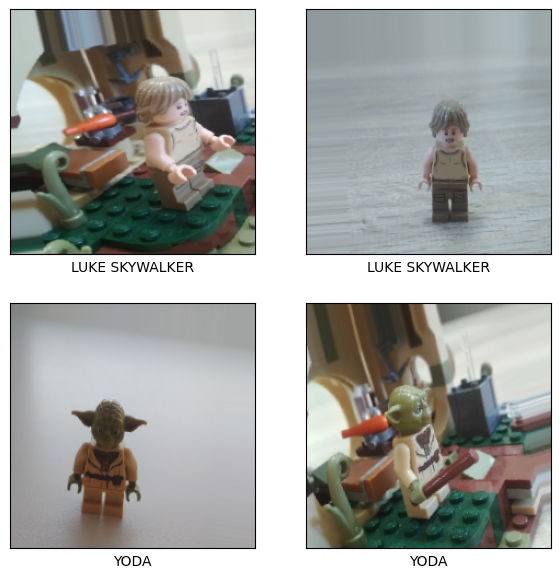

In [29]:
def show(batch, pred_labels=None):
    plt.figure(figsize=(7,7))
    for i in range(4):
        plt.subplot(2,2,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        image = batch[0][i]
        plt.imshow(image, cmap=plt.cm.binary)
        label = names[int(batch[1][i])]
        if pred_labels is not None:
            label += "\nPred: " + names[int(pred_labels[i])]
        plt.xlabel(label)
    plt.show()
    
show(train_batch)

# Building our own model


In [14]:
model = keras.models.Sequential()
model.add(layers.Conv2D(32, (3,3), strides=(1,1), padding="valid", activation='relu', input_shape=(256, 256, 3)))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(5))
print(model.summary())

## this model gives bad results

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 246016)            0         
                                                                 
 dense_3 (Dense)             (None, 64)               

# Using transfer learning

In [7]:
vgg_model = tf.keras.applications.vgg16.VGG16()
print(type(vgg_model))
vgg_model.summary()

<class 'keras.engine.functional.Functional'>
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (Ma

In [8]:
model = keras.models.Sequential()
for layer in vgg_model.layers[0:-1]:
    layer.trainable = False
    model.add(layer)
    
model.summary()

model.add(layers.Dense(5))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [9]:
# Compiling

loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optim = keras.optimizers.Adam(learning_rate=0.001)
metrics = ['accuracy']

model.compile(optimizer=optim, loss=loss, metrics=metrics)

In [10]:
# callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, verbose=2)

# Training
history = model.fit(train_batches, validation_data=val_batches, callbacks=[early_stopping], epochs=30, verbose=2)

Epoch 1/30
9/9 - 10s - loss: 2.7869 - accuracy: 0.1111 - val_loss: 2.1266 - val_accuracy: 0.4000 - 10s/epoch - 1s/step
Epoch 2/30
9/9 - 1s - loss: 2.1688 - accuracy: 0.2222 - val_loss: 1.8119 - val_accuracy: 0.2000 - 1s/epoch - 148ms/step
Epoch 3/30
9/9 - 1s - loss: 1.9378 - accuracy: 0.3611 - val_loss: 1.4303 - val_accuracy: 0.5333 - 1s/epoch - 146ms/step
Epoch 4/30
9/9 - 1s - loss: 1.4922 - accuracy: 0.3611 - val_loss: 1.2856 - val_accuracy: 0.6000 - 1s/epoch - 147ms/step
Epoch 5/30
9/9 - 1s - loss: 1.3874 - accuracy: 0.5000 - val_loss: 1.2800 - val_accuracy: 0.4667 - 1s/epoch - 152ms/step
Epoch 6/30
9/9 - 1s - loss: 1.2582 - accuracy: 0.5278 - val_loss: 1.1336 - val_accuracy: 0.6667 - 1s/epoch - 151ms/step
Epoch 7/30
9/9 - 1s - loss: 1.2744 - accuracy: 0.5278 - val_loss: 1.2381 - val_accuracy: 0.5333 - 1s/epoch - 149ms/step
Epoch 8/30
9/9 - 1s - loss: 1.1469 - accuracy: 0.5556 - val_loss: 1.0680 - val_accuracy: 0.6000 - 1s/epoch - 140ms/step
Epoch 9/30
9/9 - 1s - loss: 0.9977 - accu

In [10]:
model.save("star-wars-lego_model.h5")

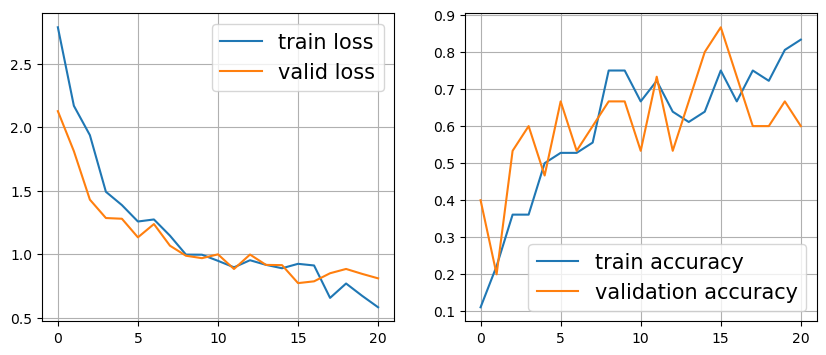

In [11]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='valid loss')
plt.grid()
plt.legend(fontsize=15)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.grid()
plt.legend(fontsize=15);

In [15]:
model.evaluate(test_batches, verbose=2)

3/3 - 0s - loss: 0.9006 - accuracy: 0.6667 - 426ms/epoch - 142ms/step


[0.9006271362304688, 0.6666666865348816]

In [16]:
predictions = model.predict(test_batches)
predictions = tf.nn.softmax(predictions)
labels = np.argmax(predictions, axis=1)

print(test_batches[0][1])
print(labels[0:4])

3/3 [==============================] - 0s 169ms/step
[0. 0. 1. 1.]
[2 3 0 3]


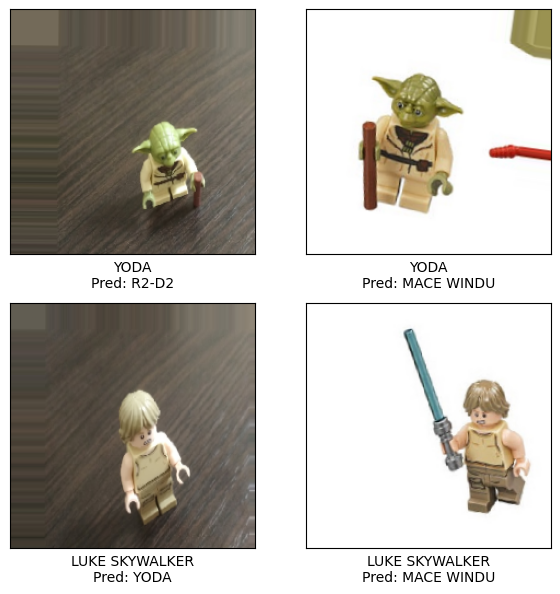

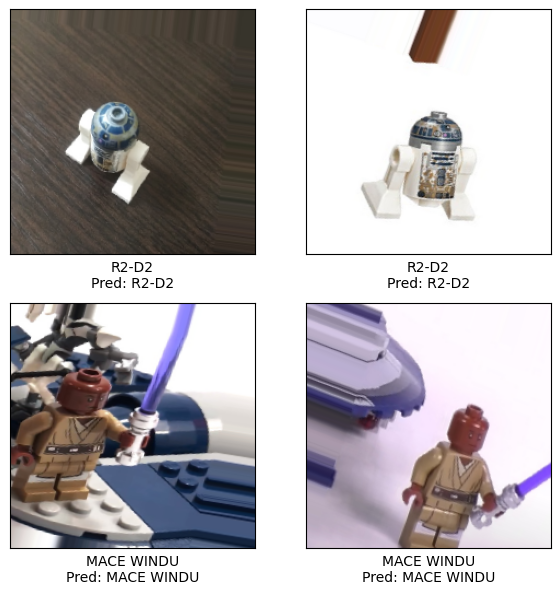

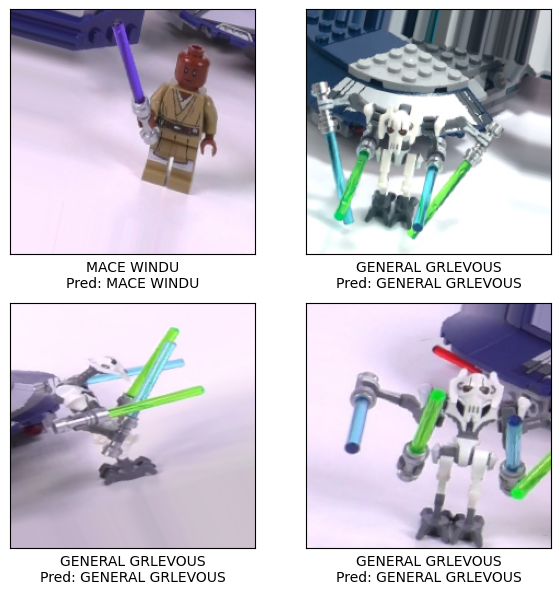

In [30]:
show(test_batches[0], labels[0:4])
show(test_batches[1], labels[4:8])
show(test_batches[2], labels[8:12])